In [1]:
from numpy.random import uniform
from numpy import zeros as npzeros
from random import expovariate
from matplotlib import pyplot as plt
import time as TIME

## Вспомогательные функции

In [2]:
# функция аналог фукнции append, но для строки внутри словаря
def dictappend(dict_part, app):
    '''
    dict_part - список, в который нужно добавить значение
    app - добавляемое значение
    '''
    dict_part.append(app)
    return dict_part

# функция аналог фукнции pop, но для строки внутри словаря
def dictpop(dict_part,popindex):
    '''
    dict_part - список, из которого нужно удалить значение
    popindex - индекс удаляемого значения
    '''
    dict_part.pop(popindex)
    return dict_part

# одна из возможных фунций для перерасчета моментов окончания обслуживания после поступления/ухода заявок
def RA_maxmin(moment, Mu, R, old_res_value, N, Rmax, maxGB, minB):
    '''
    moment - момент модельного времени (time)
    Mu - словарь списков окончания облуживания заявок по типам (Arr['Pribor'])
    R - объем "свободного" ресурса до перераспреления (Rfr)
    old_res_value - распределение ресурса до вызова функции (res_value)
    N - количество заявок на приборах (тут уже новые N, после увеличения/уменьшения и не важно на сколько)
    Rmax - максимальный объём ресурса оператора (rmax)
    maxGB - максимальный порог заявок GB (GB_max)
    minB - набор минимальных требований (b_min)
    '''
    new_res_value = {'GB':0,'BG':Rmax,'BE':Rmax}
    n = N['GB'] + N['BG'] + N['BE']
    
    if n != 0:
        if int(R/n) > (maxGB-minB['GB']):
            R2 = R - (maxGB-minB['GB'])*N['GB']
            
            if N['GB'] != 0:
                new_res_value['GB'] = maxGB
            
            if N['BG'] != 0 or N['BE'] != 0:
                new_res_value['BG'] = minB['BG'] + int(R2/(N['BG']+N['BE'])) # может немного и неправильно присваивать, но если их и нет, то ничего всё равно не будет(вроде(проверить потом при маленьком timelim)
                new_res_value['BE'] = minB['BE'] + int(R2/(N['BG']+N['BE'])) 
                
                if R2 - int(R2/(N['BG']+N['BE']))*(N['BG']+N['BE']) >= N['BE'] and N['BE'] != 0:
                    R3 = int(R2 - int(R2/(N['BG']+N['BE']))*(N['BG']+N['BE']))/N['BE']
                    new_res_value['BE'] += R3
                    R2 -= R3*N['BE']
                
                if R2 - int(R2/(N['BG']+N['BE']))*(N['BG']+N['BE']) >= N['BG'] and N['BG'] != 0:
                    new_res_value['BG'] += int((R2 - int(R2/(N['BG']+N['BE']))*(N['BG']+N['BE']))/N['BG'])
        
        else:
            new_res_value['GB'] = minB['GB'] + int(R/n)
            new_res_value['BG'] = minB['BG'] + int(R/n)
            new_res_value['BE'] = minB['BE'] + int(R/n)
            
            if R - int(R/n)*n >= N['BE'] and N['BE'] != 0:
                R3 = int((R-int(R/n)*n)/N['BE']) ###
                new_res_value['BE'] += R3
                R -= R3*N['BE']
            
            if R - int(R/n)*n >= N['BG'] and N['BG'] != 0:
                new_res_value['BG'] += int((R- (R/n)*n)/N['BG']) ###
        
        for i in range(N['BE']):
            Mu['BE'][i] = moment + (Mu['BE'][i]-moment)*old_res_value['BE']/new_res_value['BE']
        
        for i in range(N['BG']):
            Mu['BG'][i] = moment + (Mu['BG'][i]-moment)*old_res_value['BG']/new_res_value['BG']
    
    return Mu['BE'], Mu['BG'], new_res_value

## Основная функция симуляции

In [3]:
def VNO(Allocation, rmax, time_lim, GB_max, b_min, lamb, mu, file_size):
    '''
    Allocation - переданная функция перераспределения ресурса между заявками оператора
    rmax - максимальный объём ресурса оператора
    time_lim - ограничение модельного времени моделирования
    GB_max - максимальный порог заявок GB
    b_min - набор минимальных требований
    lamb - словарь для интенсивностей поступления заявок по типам
    mu - средняя продолжительность обслуживания заявок типа GB
    file_size - в случае BG и BE это пределы размеров файлов данного типа заявок
    '''
    Rfr = rmax
    Queue = {'GB': [],'BG': [],'BE': []}  # в случае BG и BE это буфер и в массивы записываются размеры файлов
    QLim = {'GB': 20,'BG': 500*1024,'BE': 150*1024}  # в случае GB это количество мест в очереди
    Arr = {'Pribor': {'GB': [],'BG': [],'BE':[]},
           'Incoming': {'GB': [expovariate(lamb['GB'])],'BG': [expovariate(lamb['BG'])],'BE': [expovariate(lamb['BE'])]} }
    res_value = {'GB':0,'BG':0,'BE':rmax}
    res = {'GB':rmax,'BG':rmax,'BE':rmax}
    
    # счетчики
    All = {'GB': 0,'BG': 0,'BE': 0}      # всего поступило заявок
    N = {'GB': 0,'BG': 0,'BE': 0}        # число заявок на обслуживании
    Block = {'GB': 0,'BG': 0,'BE': 0}    # число блокировок
    SWT = {'GB': 0,'BG': 0,'BE': 0}      # Sum Waitung Time для нахождения среднего времени ожидания
    WaStTi = {'GB': [],'BG': [],'BE': []} # здесь будут храниться моменты начала ожидания
    SST = {'GB': 0,'BG': 0,'BE': 0}      # Sum Service Time для вычисления среднего времени обслуживания (на приборе)
    StTi = {'GB': [],'BG': [],'BE': []}  # здесь будут храниться моменты начаоа обслуживания
    SQ = {'GB': 0,'BG': 0,'BE': 0}       # Sum Queue для нахождения средней длины очереди
    SBF = {'GB': 0,'BG': 0,'BE': 0}
    Nn = {'SST': {'GB': 0,'BG': 0,'BE': 0}, 'SWT': {'GB': 0,'BG': 0,'BE': 0}}
    SFR = 0     # Sum Free Resource для вычисления среденего условно свободного ресурса 
    
    time = 0
    while time < time_lim:
        min1 = time_lim
        Key = "Nothing" # чтобы не было ошибок при достижении time_lim
        
        # определяем следующее по времени событие: поступление или окончание
        for i in Arr.keys():  
            for t in Arr[i].keys():
                for j in range(len(Arr[i][t])):
                    if Arr[i][t][j] < min1:
                        min1 = Arr[i][t][j]
                        Key = i   # событие
                        Type = t  # тип заявки
                        J = j     # расположение в массиве события Key заявок типа Type
        time = min1  # передвигаем указатель модельного времени на момент подобранного события

        if Key == 'Pribor':  # уход из системы по завершению обслуживания
            SST[Type] += time - StTi[Type][J]  # StTi.pop(J)
            StTi[Type] = dictpop(StTi[Type], J)
            Nn['SST'][Type] += 1
            
            Arr['Pribor'][Type] = dictpop(Arr['Pribor'][Type],J)
            N[Type] -= 1
            Rfr += b_min[Type]
            
            for i in Queue.keys():  # приоритет отдается очереди GB
                while len(Queue[i])!=0 and Rfr >= b_min[i]: # до тех пор, пока в очереди/буфере есть заявки и у нас хватает ресурса их принять на обслуживание
                    SWT[i] += time - WaStTi[i][0]
                    Nn['SWT'][i] += 1
                    WaStTi[i] = dictpop(WaStTi[i],0)
                    
                    file = Queue[i][0]  # размер файла, который пошел на обслуживание из очереди (если i = 'BG' или 'BE')
                    Queue[i] = dictpop(Queue[i],0)
                    
                    if i != 'GB':
                        Arr['Pribor'][i] = dictappend(Arr['Pribor'][i], time+file/res[i])
                    else:
                        Arr['Pribor'][i] = dictappend(Arr['Pribor'][i], time+expovariate(mu)) 
                    
                    StTi[i] = dictappend(StTi[i],time)
                    N[i] += 1
                    Rfr -= b_min[i]
            
            # перераспределение ресурса и пересчет моментов окончания обслуживания
            Arr['Pribor']['BE'], Arr['Pribor']['BG'], res_value = Allocation(time, Arr['Pribor'], Rfr, res_value, N, rmax, GB_max, b_min)
            res['BE'] = res_value['BE']
            res['BG'] = res_value['BG']

        if Key == 'Incoming':  # поступление новой заявки в систему
            All[Type] += 1
            file = uniform(file_size[Type][0],file_size[Type][1]) # в случае 'GB' file = 1
            
            if Rfr >= b_min[Type]:
                # ресурса достаточно, поступает на прибор
                N[Type] += 1
                Rfr -= b_min[Type]
                StTi[Type] = dictappend(StTi[Type],time)
                
                if Type != 'GB':
                    Arr['Pribor'][Type] = dictappend(Arr['Pribor'][Type], time + file/res[Type])
                else:
                    Arr['Pribor']['GB'] = dictappend(Arr['Pribor']['GB'], time + expovariate(mu))
            
                Arr['Pribor']['BE'], Arr['Pribor']['BG'], res_value = Allocation(time, Arr['Pribor'], Rfr, res_value, N, rmax, GB_max, b_min)
                res['BE'] = res_value['BE']
                res['BG'] = res_value['BG']
            
            else:
                # ресурса не хватило
                if file + sum(Queue[Type]) <= QLim[Type]:
                    # место в очереди/буфере хватает
                    Queue[Type] = dictappend(Queue[Type], file)
                    WaStTi[Type] = dictappend(WaStTi[Type], time)
                else:
                    # блокировка из-за нехватки места
                    Block[Type] += 1
            
            SFR += Rfr
            SQ[Type] += len(Queue[Type])
            SBF[Type] += sum(Queue[Type])
            
            #следующая заявка поступит в момент:
            Arr['Incoming'][Type] = [time + expovariate(lamb[Type])]
    
    return All, Block, SQ, SST, SWT, SFR, SBF, Nn

## Параметры

In [4]:
numb_us = 30
b_min = {'GB':int(0.3*1024), # 1/3 MB/s
         'BG':1*1024,        # 1 MB/s
         'BE':8}             # 8 KB/s
GB_max = 5*1024
time_lim = 10000
mu = 1/60    # средняя продолжительность = mu^(-1) = 60 секунд
lamb = {'GB': 0.4286*numb_us,'BG': 0.3333*numb_us, 'BE': 0.2381*numb_us}
file_size = {'GB': [1,1],
             'BG': [4*1024,20*1024],  #пределы размеров файла
             'BE': [128,2.5*1024]}  #пределы размеров файла

## Запуск моделирования

In [5]:
S = npzeros((15,10)) # матрица для записи результатов симулирования
L = []
prog_st_time = TIME.time()  # для вычисления времени работы программы

for i in range(10):
    st_time = TIME.time()
    rm = 340 + 5*i   # максимальный объём ресурса этого шага
    L.append(rm)
    rm = rm*1024   # перевод в КБ/с
    
    a, b, sq, sst, swt, sr, sbf, nn = VNO(RA_maxmin, rm, time_lim, GB_max, b_min, lamb, mu, file_size)
    
    print('продолжительность работы функции:',TIME.time()-st_time)
    
    aa = a['GB']+a['BG']+a['BE']
    S[0][i] = b['GB']/a['GB']             # процент заблокированных заявок GB
    S[1][i] = b['BG']/a['BG']             # процент заблокированных заявок BG
    S[2][i] = b['BE']/a['BE']             # процент заблокированных заявок BE
    
    S[3][i] = sq['GB']/aa                 # средняя длина очереди GB
    S[4][i] = sq['BG']/aa                 # средняя длина очереди BG
    S[5][i] = sq['BE']/aa                 # средняя длина очереди BE
    
    S[6][i] = sst['GB']/nn['SST']['GB']   # среднее время обслуживания GB
    S[7][i] = sst['BG']/nn['SST']['BG']   # среднее время обслуживания BG
    S[8][i] = sst['BE']/nn['SST']['BE']   # среднее время обслуживания BE
    
    if nn['SWT']['GB'] != 0:
        S[9][i] = swt['GB']/nn['SWT']['GB']   # среднее время ожидания GB
    if nn['SWT']['BG'] != 0:
        S[10][i] = swt['BG']/nn['SWT']['BG']  # среднее время ожидания BG
    if nn['SWT']['BE'] != 0:
        S[11][i] = swt['BE']/nn['SWT']['BE']  # среднее время ожидания BE
    
    S[12][i] = sr/aa                       # средний объём условно свободного ресурса
    
    S[13][i] = sbf['BG']/(a['BG']*1024*500)  # так как объём буффера в нашем примере = 500МБ
    S[14][i] = sbf['BE']/(a['BE']*1024*150)  # так как объём буффера в нашем примере = 150МБ

prog_end_time = TIME.time()
print('все иттерации пройдены за:', (prog_end_time-prog_st_time)//60, 'минут', (prog_end_time-prog_st_time)%60, 'секунд') 

продолжительность работы функции: 524.7184772491455
продолжительность работы функции: 503.62971091270447
продолжительность работы функции: 502.8355178833008
продолжительность работы функции: 509.8854842185974
продолжительность работы функции: 588.1375489234924
продолжительность работы функции: 379.86799335479736
продолжительность работы функции: 6531.755620479584
продолжительность работы функции: 219.7777533531189
продолжительность работы функции: 271.1583602428436
продолжительность работы функции: 242.0455286502838
все иттерации пройдены за: 171.0 минут 13.836080074310303 секунд


## Графики

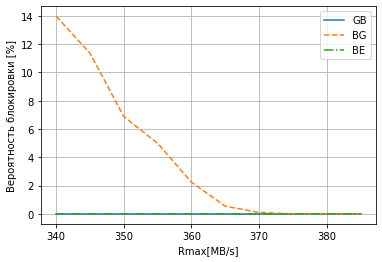

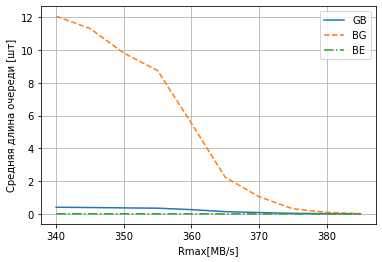

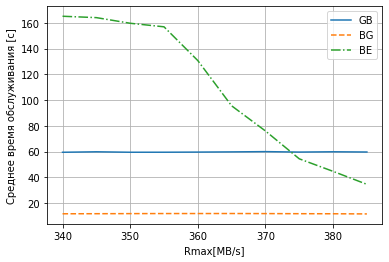

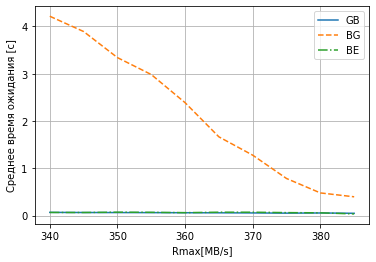

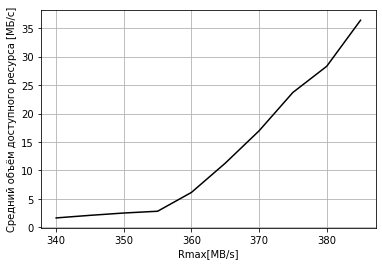

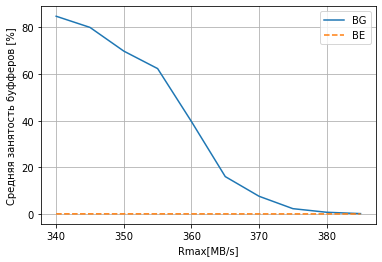

In [6]:
lines = ['-','--', '-.']

for i,apl in enumerate(['GB','BG','BE']):
    plt.plot(L, S[i]*100, lines[i], label=apl)
plt.ylabel('Вероятность блокировки [%]')
plt.xlabel('Rmax[MB/s]')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

for i,apl in enumerate(['GB','BG','BE']):
    plt.plot(L, S[i+3], lines[i], label=apl)
plt.xlabel('Rmax[MB/s]')
plt.ylabel('Средняя длина очереди [шт]')
plt.legend(loc='best')
plt.grid(True)
plt.show()

for i,apl in enumerate(['GB','BG','BE']):
    plt.plot(L, S[i+6], lines[i], label=apl)
plt.xlabel('Rmax[MB/s]')
plt.ylabel('Среднее время обслуживания [с]')
plt.legend(loc='best')
plt.grid(True)
plt.show()

for i,apl in enumerate(['GB','BG','BE']):
    plt.plot(L, S[i+9], lines[i], label=apl)
plt.xlabel('Rmax[MB/s]')
plt.ylabel('Среднее время ожидания [с]')
plt.legend(loc='best')
plt.grid(True)
plt.show()

plt.plot(L,S[12]/1024, 'k')
plt.xlabel('Rmax[MB/s]')
plt.ylabel('Средний объём доступного ресурса [МБ/с]')
plt.grid(True)
plt.show()

for i,apl in enumerate(['BG','BE']):
    plt.plot(L, S[i+13]*100, lines[i], label=apl)
plt.xlabel('Rmax[MB/s]')
plt.ylabel('Средняя занятость буфферов [%]')
plt.legend(loc='best')
plt.grid(True)
plt.show()